# Analyse de performance business

**Objectif :**
Analyser un dataset e-commerce pour identifier les KPIs clés, explorer les tendances et proposer des recommandations business basées sur les données.

**Questions métier :**
- Quel est le chiffre d’affaires global et son évolution dans le temps ?
- Quel est le nombre et le type de transactions réalisées ?
- Quelle est la valeur moyenne d’un panier ?
- Quels pays contribuent le plus au chiffre d’affaires ?
- Quelles recommandations peut-on formuler à partir des observations ?

## Outils utilisés
- Python
- Pandas
- Jupyter Notebook
- Matplotlib

## Méthodologie

Pour analyser la performance business, nous suivrons cette démarche :

1. Inspection du dataset pour comprendre les types de données, la présence de valeurs manquantes et la structure générale.
2. Création de variables métier utiles pour calculer les KPI (ex. Revenue).
3. Identification et gestion des valeurs aberrantes (transactions négatives ou extrêmement élevées) afin de ne pas biaiser les KPIs.
4. Calcul des KPI clés : chiffre d’affaires, nombre de transactions, panier moyen, répartition géographique.
5. Visualisation et interprétation des tendances pour formuler des recommandations business.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Chargement des données
df = pd.read_csv("data/online_retail.csv")

# Aperçu rapide
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


**Observation initiale :**
- Le dataset contient des informations sur les transactions : InvoiceNo, StockCode, Description, Quantity, InvoiceDate, UnitPrice, CustomerID, Country
- Certaines colonnes nécessitent un nettoyage ou une conversion avant l’analyse (ex. InvoiceDate à mettre au bon format)

In [2]:
df.info()
df.describe()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

**Synthèse inspection :**
- InvoiceDate est au format texte et sera converti en datetime pour permettre les regroupements temporels
- CustomerID contient beaucoup des valeurs null, à prendre en compte pour certaines analyses

In [3]:
# Conversion de InvoiceDate en format datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Création de la variable Revenue
df['Revenue'] = df['Quantity'] * df['UnitPrice']

# Analyse de la variable Revenue
print(df['Revenue'].describe())

count    541909.000000
mean         17.987795
std         378.810824
min     -168469.600000
25%           3.400000
50%           9.750000
75%          17.400000
max      168469.600000
Name: Revenue, dtype: float64


**Préparation :**
- Conversion des dates pour permettre l’analyse temporelle
- Calcul de Revenue pour avoir une mesure clé de performance par transaction
- Analyse de la variable Revenue pour en connaître la médiane ainsi que la présence ou non de valeurs abberantes

In [4]:
# Filtrer les ventes négatives
outliers_neg = df[df['Revenue'] < 0]

# Afficher les 5 transactions négatives les plus extrêmes
outliers_neg_sorted = outliers_neg.nsmallest(5, 'Revenue')
outliers_neg_sorted[['InvoiceNo', 'Revenue']]

,InvoiceNo,Revenue
540422,C581484,-168469.60
61624,C541433,-77183.60
222681,C556445,-38970.00
524602,C580605,-17836.46
43702,C540117,-16888.02


In [5]:
# Filtrer les ventes extremement positives
outliers_pos = df[df['Revenue'] > 1000]

# Afficher les 5 transactions positives les plus extrêmes
outliers_pos_sorted = outliers_pos.nlargest(5, 'Revenue')
outliers_pos_sorted[['InvoiceNo', 'Revenue']]

,InvoiceNo,Revenue
540421,581483,168469.60
61619,541431,77183.60
222680,556444,38970.00
15017,537632,13541.33
299982,A563185,11062.06


**Analyse des valeurs aberrantes :**

L’analyse de la variable Revenue met en évidence la présence de transactions extrêmement élevées ou négatives.

Ces valeurs correspondent potentiellement à :
- des commandes exceptionnelles
- des annulations, remboursements ou avoirs

Afin de garantir une lecture fiable des indicateurs de performance globaux, ces valeurs atypiques sont isolées pour l’analyse exploratoire, puis exclues des visualisations descriptives, sans être supprimées du dataset original.

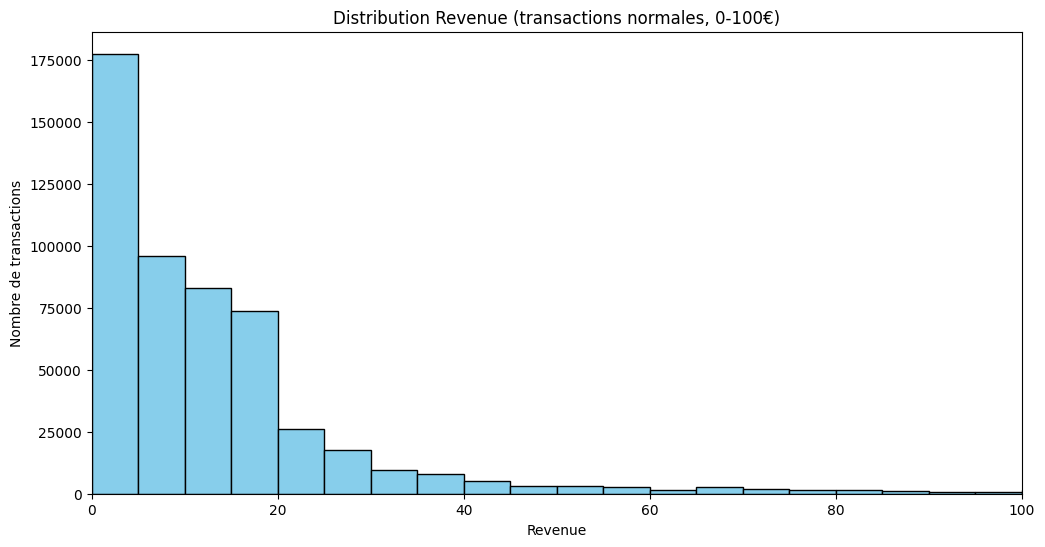

In [6]:
# Transactions positives normales
df_positive = df[(df['Revenue'] > 0) & (df['Revenue'] <= 1000)].copy()

# Histogramme pour visualiser la distribution des transactions
plt.figure(figsize=(12,6))
plt.hist(df_positive['Revenue'], bins=200, color='skyblue', edgecolor='black')
plt.title('Distribution Revenue (transactions normales, 0-100€)')
plt.xlabel('Revenue')
plt.ylabel('Nombre de transactions')
plt.xlim(0, 100)  # on se concentre sur la majorité des ventes
plt.show()

**Analyse des Revenues :**
- Les transactions négatives correspondent probablement à des retours et sont utiles pour certaines analyses, mais sont exclues des KPI globaux.
- Les transactions élevées (>100€) sont rares et exclues pour ne pas fausser les indicateurs.
- La majorité des transactions se situe sur de faibles montants, ce qui est typique pour du e-commerce.

In [7]:
# Création d'une variable mois pour analyses temporelles
df_positive['YearMonth'] = df_positive['InvoiceDate'].dt.to_period('M')

# KPI globaux
total_revenue = df_positive['Revenue'].sum()
total_transactions = df_positive['InvoiceNo'].nunique()
average_basket = total_revenue / total_transactions
unique_customers = df_positive['CustomerID'].nunique()
revenue_per_customer = total_revenue / unique_customers

### KPI globaux – Lecture business

- **Chiffre d’affaires total :** Performance globale de l’entreprise
- **Nombre de transactions :** Indicateur de l’intensité d’activité
- **Panier moyen :** Valeur moyenne des commandes
- **Clients uniques et CA par client :** Compréhension de la contribution client au chiffre d’affaires

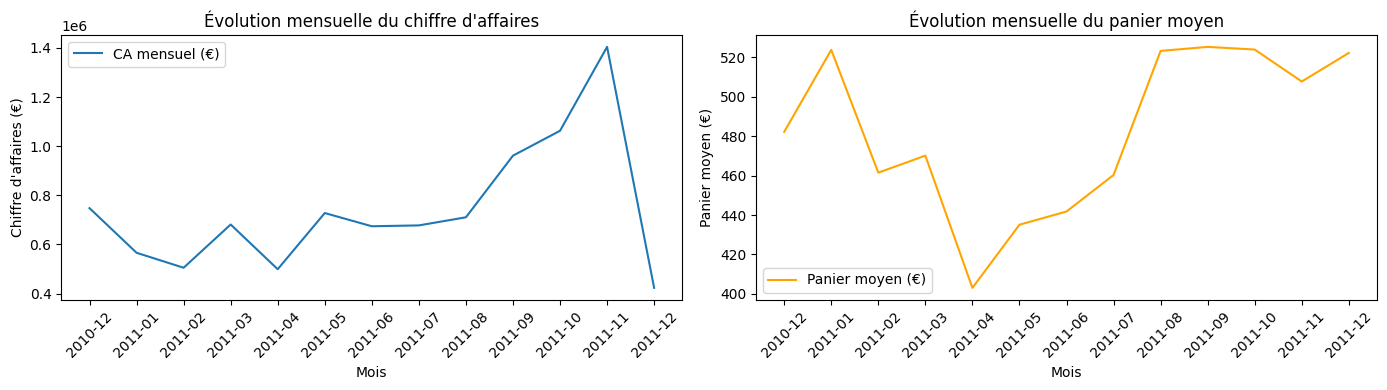

In [8]:
monthly_revenue = df_positive.groupby('YearMonth')['Revenue'].sum().reset_index()
monthly_transactions = df_positive.groupby('YearMonth')['InvoiceNo'].nunique().reset_index()
monthly_avg_basket = monthly_revenue['Revenue'] / monthly_transactions['InvoiceNo']

fig, axes = plt.subplots(1, 2, figsize=(14,4))

# Graphique 1 : Chiffre d'affaires
axes[0].plot(
    monthly_revenue['YearMonth'].astype(str),
    monthly_revenue['Revenue'],
    label='CA mensuel (€)'
)
axes[0].set_title("Évolution mensuelle du chiffre d'affaires")
axes[0].set_xlabel("Mois")
axes[0].set_ylabel("Chiffre d'affaires (€)")
axes[0].tick_params(axis='x', rotation=45)
axes[0].legend()

# Graphique 2 : Panier moyen
axes[1].plot(
    monthly_revenue['YearMonth'].astype(str),
    monthly_avg_basket,
    label='Panier moyen (€)',
    color='orange'
)
axes[1].set_title("Évolution mensuelle du panier moyen")
axes[1].set_xlabel("Mois")
axes[1].set_ylabel("Panier moyen (€)")
axes[1].tick_params(axis='x', rotation=45)
axes[1].legend()

plt.tight_layout()
plt.show()

**Observation :**
- Le chiffre d’affaires et le panier moyen montrent des variations mensuelles
- On peut identifier les périodes de forte activité et de faible activité

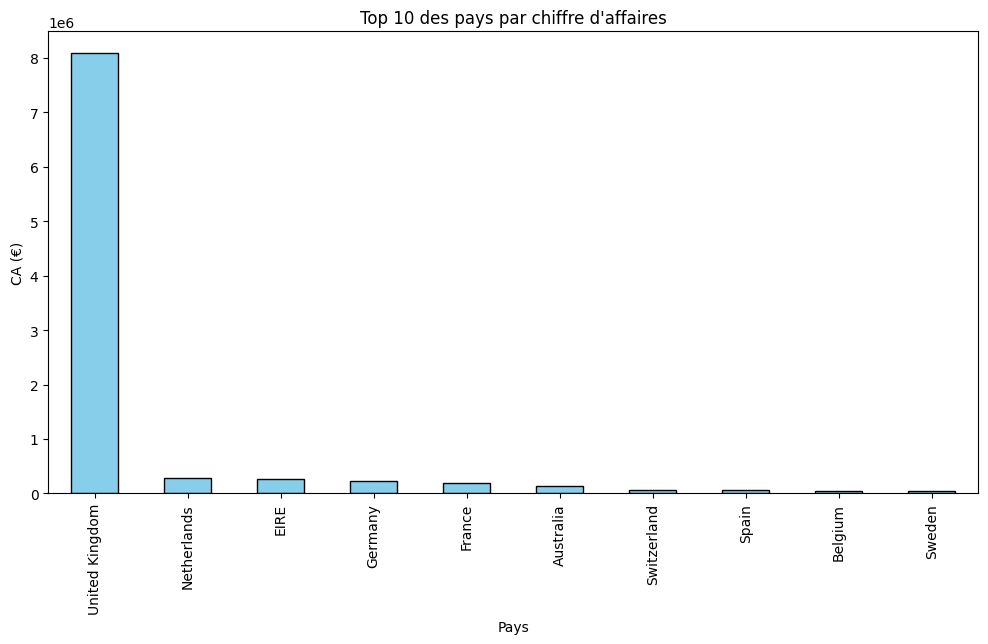

In [9]:
country_revenue = df_positive.groupby('Country')['Revenue'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(12,6))
country_revenue.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Top 10 des pays par chiffre d'affaires")
plt.xlabel("Pays")
plt.ylabel("CA (€)")
plt.show()

**Lecture business :**
- Les pays en tête contribuent majoritairement au chiffre d’affaires (United Kingdom)
- Cette information est utile pour orienter la stratégie marketing et commerciale

## Conclusion – Performance business

- La majorité du chiffre d’affaires provient de quelques pays clés
- Le chiffre d’affaires et le nombre de transactions montrent des tendances temporelles claires
- Le panier moyen indique que la plupart des commandes sont de faible montant, avec quelques transactions exceptionnelles
- Les valeurs aberrantes ont été identifiées et exclues des KPI globaux pour garantir des indicateurs fiables

**Prochaine étape :** segmenter les clients pour identifier des groupes de comportements et formuler des recommandations ciblées (Projet 2)